# Combined CDOM and SST Anomaly Analysis

This notebook demonstrates an end-to-end pipeline for processing satellite L2 RRS data to derive CDOM (Colored Dissolved Organic Matter) and MUR L4 data for SST (Sea Surface Temperature) Anomaly. It then indexes CDOM data to a 0-1 range (mapping 0.2→0, 1.0→1) and SST Anomaly to a -1 to 1 range, multiplies them, and visualizes the result.

**Pipeline Steps:**

1.  **Import libraries** and set up the environment.
2.  **Define constants and parameters** for CDOM calculation, SST Anomaly processing, shared geographical bounding box, and binning.
3.  **CDOM Processing:**
    *   Search for and load L2 RRS NetCDF files.
    *   Extract RRS data (GPU accelerated).
    *   Calculate CDOM.
    *   Clip, bin, and interpolate CDOM data.
4.  **SST Anomaly Processing:**
    *   Search for and load MUR L4 SST Anomaly NetCDF files.
    *   Extract SST Anomaly data (GPU accelerated).
    *   Clip, bin, and interpolate SST Anomaly data to the same grid as CDOM.
5.  **Combined Analysis:**
    *   Index CDOM data: map [0.2, 1.0] to [0, 1] with clamping
    *   Normalize SST Anomaly data to [-1, 1] range
    *   Multiply the indexed CDOM and normalized SST Anomaly data
    *   Visualize the combined product

### Library Imports

Import essential libraries for file handling, numerical operations, plotting, and custom processing for both L2 and L3 data.

In [1]:
# Import essential libraries
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d
import xarray as xr # For inspecting NetCDF variables
import matplotlib.colors
import cmocean # For specialized oceanographic colormaps

import sys
sys.dont_write_bytecode = True

# Import custom pipeline components
import importlib
import l2_pipeline # For L2 RRS data
importlib.reload(l2_pipeline)
from l2_pipeline import L2DatasetLoader, GPUDataExtractor as GPUDataExtractorL2, SelectiveInterpolator as SelectiveInterpolatorL2

import l3_pipeline # For L3 SST Anomaly data
importlib.reload(l3_pipeline)
from l3_pipeline import L3DatasetLoader, GPUDataExtractor as GPUDataExtractorL3, SelectiveInterpolator as SelectiveInterpolatorL3

# Suppress RuntimeWarnings that can occur with NaNs in calculations
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib') # Ignore Matplotlib UserWarnings for set_bad

### Define Constants and Parameters

Define constants for CDOM calculation, SST Anomaly processing, geographical area, binning, and data paths.

In [2]:
# --- Shared Geographical and Binning Parameters ---
lon_min, lon_max = -95.0, -88.0
lat_min, lat_max = 27.5, 30.5

lat_bins = 200 # Number of latitude bins (height)
lon_bins = 300 # Number of longitude bins (width)

# --- CDOM Calculation Constants ---
B0 = 0.2487
B1 = 14.028
B2 = 4.085

# --- L2 RRS Data Configuration (for CDOM) ---
data_dir_l2_rrs = r"E:\satdata\Texas Louisiana Shelf_2024-06-01_2024-06-30"
rrs_vars_list = ['Rrs_412', 'Rrs_555']
rrs_data_group = 'geophysical_data'
interpolation_threshold_cdom = 32

# --- MUR L4 SST Anomaly Data Configuration ---
data_dir_sst_anom = r"E:\satdata\MUR-JPL-L4-GLOB-v4.1_Texas Louisiana Shelf_2024-06-01_2024-06-30"
sst_anom_variable_to_plot = 'sst_anomaly'
sst_anom_variables_to_load = [sst_anom_variable_to_plot]
min_ssta_threshold = -10.0 # SSTA threshold
max_ssta_threshold = 10.0
interpolation_threshold_sst_anom = 32

print(f"Region: Lon ({lon_min}, {lon_max}), Lat ({lat_min}, {lat_max})")
print(f"Grid: {lat_bins} lat bins, {lon_bins} lon bins")

Region: Lon (-95.0, -88.0), Lat (27.5, 30.5)
Grid: 200 lat bins, 300 lon bins


## CDOM Data Processing

### Searching for L2 RRS Data Files (CDOM)

In [3]:
nc_files_rrs = glob.glob(os.path.join(data_dir_l2_rrs, '**', '*.nc'), recursive=True)
if not nc_files_rrs:
    print(f"Warning: No .nc files found for L2 RRS in {data_dir_l2_rrs}.")
else:
    print(f"Found {len(nc_files_rrs)} L2 RRS files for CDOM processing.")

Found 42 L2 RRS files for CDOM processing.


### Loading and Extracting L2 RRS Data (CDOM)

In [4]:
lon_rrs_flat, lat_rrs_flat, rrs_vars_data_flat = np.array([]), np.array([]), {var: np.array([]) for var in rrs_vars_list}

if nc_files_rrs:
    try:
        loader_rrs = L2DatasetLoader(variables=rrs_vars_list, group=rrs_data_group)
        datasets_rrs = loader_rrs.load_multiple(nc_files_rrs)
        print(f"Successfully loaded {len(datasets_rrs)} L2 RRS datasets for CDOM.")
        
        extractor_rrs = GPUDataExtractorL2(variables=rrs_vars_list)
        lon_rrs_flat, lat_rrs_flat, rrs_vars_data_flat = extractor_rrs.extract(datasets_rrs)
        print(f"L2 RRS data extraction for CDOM complete. Extracted {len(lon_rrs_flat)} data points.")
    except Exception as e:
        print(f"Error during L2 RRS data loading/extraction: {e}")
else:
    print("No L2 RRS files found to process for CDOM.")

Successfully loaded 42 L2 RRS datasets for CDOM.
L2 RRS data extraction for CDOM complete. Extracted 12725916 data points.
L2 RRS data extraction for CDOM complete. Extracted 12725916 data points.


### CDOM Calculation, Clipping, Binning, and Interpolation

In [5]:
binned_cdom_interpolated = np.full((lat_bins, lon_bins), np.nan)
lat_edges_grid, lon_edges_grid = None, None

if lon_rrs_flat.size > 0 and rrs_vars_data_flat:
    Rss412 = rrs_vars_data_flat.get(rrs_vars_list[0], np.array([]))
    Rss555 = rrs_vars_data_flat.get(rrs_vars_list[1], np.array([]))
    
    if Rss412.size > 0 and Rss555.size > 0:
        term_ratio = Rss412 / Rss555
        term_numerator = term_ratio - B0
        term_division = term_numerator / B2
        valid_log_mask = term_division > 0
        
        cdom_values = np.full_like(term_division, np.nan)
        if np.any(valid_log_mask):
            cdom_values[valid_log_mask] = (np.log(term_division[valid_log_mask])) / (-B1)
        
        valid_mask = ~np.isnan(lon_rrs_flat) & ~np.isnan(lat_rrs_flat) & ~np.isnan(cdom_values)
        final_lon_cdom = lon_rrs_flat[valid_mask]
        final_lat_cdom = lat_rrs_flat[valid_mask]
        final_cdom_raw = cdom_values[valid_mask]

        clip_mask_cdom = (
            (final_lon_cdom >= lon_min) & (final_lon_cdom <= lon_max) &
            (final_lat_cdom >= lat_min) & (final_lat_cdom <= lat_max)
        )
        clipped_lon_cdom = final_lon_cdom[clip_mask_cdom]
        clipped_lat_cdom = final_lat_cdom[clip_mask_cdom]
        clipped_cdom_raw = final_cdom_raw[clip_mask_cdom]
        print(f"Clipped CDOM data. {len(clipped_lon_cdom)} points remaining.")

        if clipped_lon_cdom.size > 0:
            binned_cdom_raw_stat, lat_edges_grid, lon_edges_grid, _ = binned_statistic_2d(
                clipped_lat_cdom, clipped_lon_cdom, clipped_cdom_raw,
                statistic='mean', bins=[lat_bins, lon_bins], 
                range=[[lat_min, lat_max], [lon_min, lon_max]]
            )
            binned_cdom_interpolated = SelectiveInterpolatorL2.interpolate(
                binned_cdom_raw_stat, lat_edges_grid, lon_edges_grid, threshold=interpolation_threshold_cdom
            )
            print("CDOM processing complete.")
        else:
            print("No CDOM data in bounding box.")
    else:
        print("Skipping CDOM calculation: Rrs data not available or empty.")
else:
    print("Skipping CDOM processing: No L2 RRS data extracted.")

if lat_edges_grid is None or lon_edges_grid is None:
    lat_edges_grid = np.linspace(lat_min, lat_max, lat_bins + 1)
    lon_edges_grid = np.linspace(lon_min, lon_max, lon_bins + 1)
    print("Warning: CDOM grid created from linspace as no data was available.")

Clipped CDOM data. 844876 points remaining.
CDOM processing complete.
CDOM processing complete.


## SST Anomaly Data Processing

### Searching for MUR L4 Data Files (SST Anomaly)

In [6]:
nc_files_sst_anom = glob.glob(os.path.join(data_dir_sst_anom, '**', '*.nc'), recursive=True)
if not nc_files_sst_anom:
    print(f"Warning: No .nc files found for SST Anomaly in {data_dir_sst_anom}.")
else:
    print(f"Found {len(nc_files_sst_anom)} SST Anomaly files.")

Found 31 SST Anomaly files.


### Loading and Extracting MUR L4 Data (SST Anomaly)

In [7]:
lon_ssta_flat, lat_ssta_flat, ssta_vars_data_flat = np.array([]), np.array([]), {var: np.array([]) for var in sst_anom_variables_to_load}

if nc_files_sst_anom:
    try:
        bbox = (lon_min, lon_max, lat_min, lat_max)
        loader_ssta = L3DatasetLoader(variables=sst_anom_variables_to_load, bbox=bbox)
        datasets_ssta = loader_ssta.load_multiple(nc_files_sst_anom)
        print(f"Successfully loaded {len(datasets_ssta)} SST Anomaly datasets.")
        
        extractor_ssta = GPUDataExtractorL3(variables=sst_anom_variables_to_load)
        lon_ssta_flat, lat_ssta_flat, ssta_vars_data_flat = extractor_ssta.extract(datasets_ssta)
        print(f"SST Anomaly data extraction complete. Extracted {len(lon_ssta_flat)} data points.")
    except Exception as e:
        print(f"Error during SST Anomaly data loading/extraction: {e}")
else:
    print("No SST Anomaly files found to process.")

f:\Programming\GitHub\nasa-murep-local\cdom_sst\l3_pipeline.py:24: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(file_path)
f:\Programming\GitHub\nasa-murep-local\cdom_sst\l3_pipeline.py:24: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's defaul

Successfully loaded 31 SST Anomaly datasets.
SST Anomaly data extraction complete. Extracted 4896698 data points.
SST Anomaly data extraction complete. Extracted 4896698 data points.


### Clipping, Binning, and Interpolating SST Anomaly Data

In [8]:
binned_sst_anom_interpolated = np.full((lat_bins, lon_bins), np.nan)

if lon_ssta_flat.size > 0 and sst_anom_variable_to_plot in ssta_vars_data_flat:
    all_ssta = ssta_vars_data_flat[sst_anom_variable_to_plot]
    
    all_ssta[(all_ssta < min_ssta_threshold) | (all_ssta > max_ssta_threshold)] = np.nan
    print(f"SSTA thresholded outside ({min_ssta_threshold}, {max_ssta_threshold})°C.")

    valid_mask_ssta = ~np.isnan(lon_ssta_flat) & ~np.isnan(lat_ssta_flat) & ~np.isnan(all_ssta)
    final_lon_ssta = lon_ssta_flat[valid_mask_ssta]
    final_lat_ssta = lat_ssta_flat[valid_mask_ssta]
    final_ssta_processed = all_ssta[valid_mask_ssta]

    # Data is already clipped by L3 loader, but we can bin directly
    if final_lon_ssta.size > 0:
        binned_ssta_raw_stat, _, _, _ = binned_statistic_2d(
            final_lat_ssta, final_lon_ssta, final_ssta_processed,
            statistic='mean', bins=[lat_edges_grid, lon_edges_grid]
        )
        
        binned_sst_anom_interpolated = SelectiveInterpolatorL3.interpolate(
            binned_ssta_raw_stat, lat_edges_grid, lon_edges_grid, threshold=interpolation_threshold_sst_anom
        )
        print("SST Anomaly processing complete.")
    else:
        print("No valid SST Anomaly data points to bin.")
else:
    print("No valid SST Anomaly data to process.")

SSTA thresholded outside (-10.0, 10.0)°C.
SST Anomaly processing complete.
SST Anomaly processing complete.


## Combined CDOM-SST Anomaly Analysis and Plotting

In [9]:
# --- Helper functions for normalization ---
def normalize_cdom_custom(data_array, cdom_min=0.2, cdom_max=1.0):
    """Normalizes CDOM data: maps [cdom_min, cdom_max] to [0, 1] and clamps values outside this range."""
    # Clamp the data to the specified range [cdom_min, cdom_max]
    clamped_data = np.clip(data_array, cdom_min, cdom_max)
    # Normalize the clamped data to the range [0, 1]
    normalized_array = (clamped_data - cdom_min) / (cdom_max - cdom_min)
    # Preserve original NaNs
    normalized_array[np.isnan(data_array)] = np.nan
    return normalized_array

def normalize_data_range(data_array, p_low=5, p_high=95, target_min=-1, target_max=1):
    """Normalizes a 2D numpy array to [target_min, target_max] using percentiles."""
    original_nans = np.isnan(data_array)
    valid_values = data_array[~original_nans]
    if valid_values.size == 0: return np.full_like(data_array, np.nan)

    min_val = np.percentile(valid_values, p_low)
    max_val = np.percentile(valid_values, p_high)
    if min_val >= max_val: min_val, max_val = np.nanmin(valid_values), np.nanmax(valid_values)
    if np.isclose(min_val, max_val): return np.full_like(data_array, (target_min + target_max) / 2.0)
    
    normalized_01 = (data_array - min_val) / (max_val - min_val)
    normalized_array = normalized_01 * (target_max - target_min) + target_min
    normalized_array = np.clip(normalized_array, target_min, target_max)
    normalized_array[original_nans] = np.nan
    return normalized_array

# --- Normalization and Combination ---
# Normalize CDOM using the custom function (0.2->0, 1.0->1)
cdom_normalized = normalize_cdom_custom(binned_cdom_interpolated, cdom_min=0.2, cdom_max=1.0)
print(f"Normalized CDOM (custom): {np.nanmin(cdom_normalized):.4f} to {np.nanmax(cdom_normalized):.4f}")

# Normalize SST Anomaly to -1 to 1 range
sst_anom_normalized = normalize_data_range(binned_sst_anom_interpolated, target_min=-1, target_max=1)
print(f"Normalized SST Anomaly (-1 to 1): {np.nanmin(sst_anom_normalized):.4f} to {np.nanmax(sst_anom_normalized):.4f}")

# Multiply the two normalized maps
combined_product = cdom_normalized * sst_anom_normalized
print(f"Combined product range: {np.nanmin(combined_product):.4f} to {np.nanmax(combined_product):.4f}")

Normalized CDOM (custom): 0.0000 to 0.6183
Normalized SST Anomaly (-1 to 1): -1.0000 to 1.0000
Combined product range: -0.5044 to 0.5092


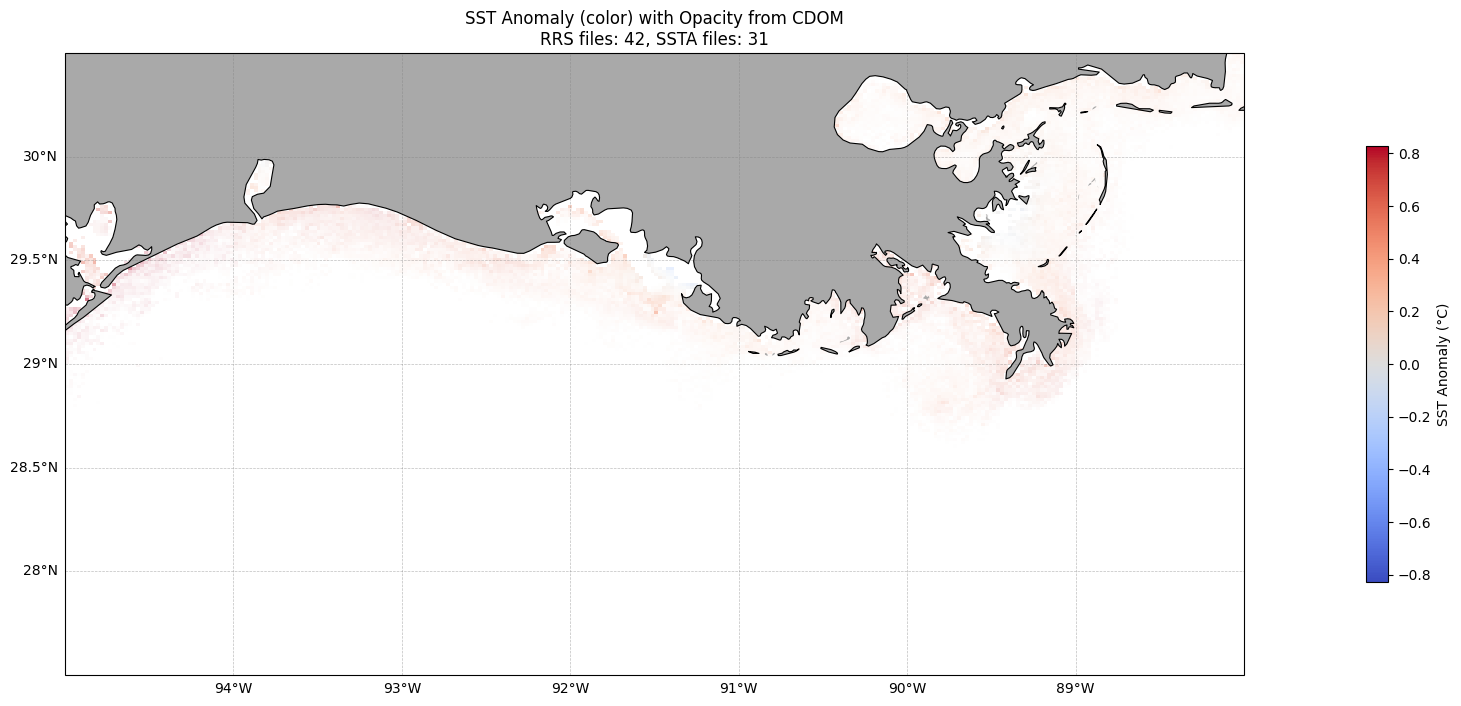

In [10]:
# --- Plotting ---
lon_span_plot = lon_edges_grid[-1] - lon_edges_grid[0]
lat_span_plot = lat_edges_grid[-1] - lat_edges_grid[0]
geo_aspect_ratio = lon_span_plot / lat_span_plot if lat_span_plot != 0 else 1
fig_height = 7
fig_width = min(max(fig_height * geo_aspect_ratio, 5), 16)

fig = plt.figure(figsize=(fig_width, fig_height))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_edges_grid[0], lon_edges_grid[-1], lat_edges_grid[0], lat_edges_grid[-1]], crs=ccrs.PlateCarree())

# --- Data for Plotting ---
ssta_data_for_color = binned_sst_anom_interpolated
cdom_data_for_alpha = cdom_normalized 

# --- SST Anomaly Colormap and Normalization ---
ssta_cmap = plt.get_cmap('coolwarm')
ssta_cmap.set_bad(color='lightgray', alpha=0.0)

valid_ssta_plot_vals = ssta_data_for_color[~np.isnan(ssta_data_for_color)]
v_abs = np.percentile(np.abs(valid_ssta_plot_vals), 95) if valid_ssta_plot_vals.size > 0 else 2.0
vmin_ssta, vmax_ssta = -v_abs, v_abs
norm_ssta = matplotlib.colors.Normalize(vmin=vmin_ssta, vmax=vmax_ssta)

# --- Create RGBA image ---
rgba_image = ssta_cmap(norm_ssta(ssta_data_for_color))
alpha_channel = np.nan_to_num(cdom_data_for_alpha, nan=0.0)
rgba_image[..., 3] = np.where(~np.isnan(ssta_data_for_color), alpha_channel, rgba_image[..., 3])

# --- Plotting the RGBA image ---
img = ax.imshow(rgba_image, origin='lower', 
                extent=[lon_edges_grid[0], lon_edges_grid[-1], lat_edges_grid[0], lat_edges_grid[-1]],
                transform=ccrs.PlateCarree(), aspect='auto')

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=3)
ax.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Colorbar for SST Anomaly
sm = matplotlib.cm.ScalarMappable(cmap=ssta_cmap, norm=norm_ssta)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label='SST Anomaly (°C)', shrink=0.7, pad=0.08)

plt.title(f"SST Anomaly (color) with Opacity from CDOM\n"
          f"RRS files: {len(nc_files_rrs)}, SSTA files: {len(nc_files_sst_anom)}", fontsize=12)
plt.tight_layout(pad=0.5)
plt.show()

### (Optional) Plotting Raw CDOM and SST Anomaly for Comparison

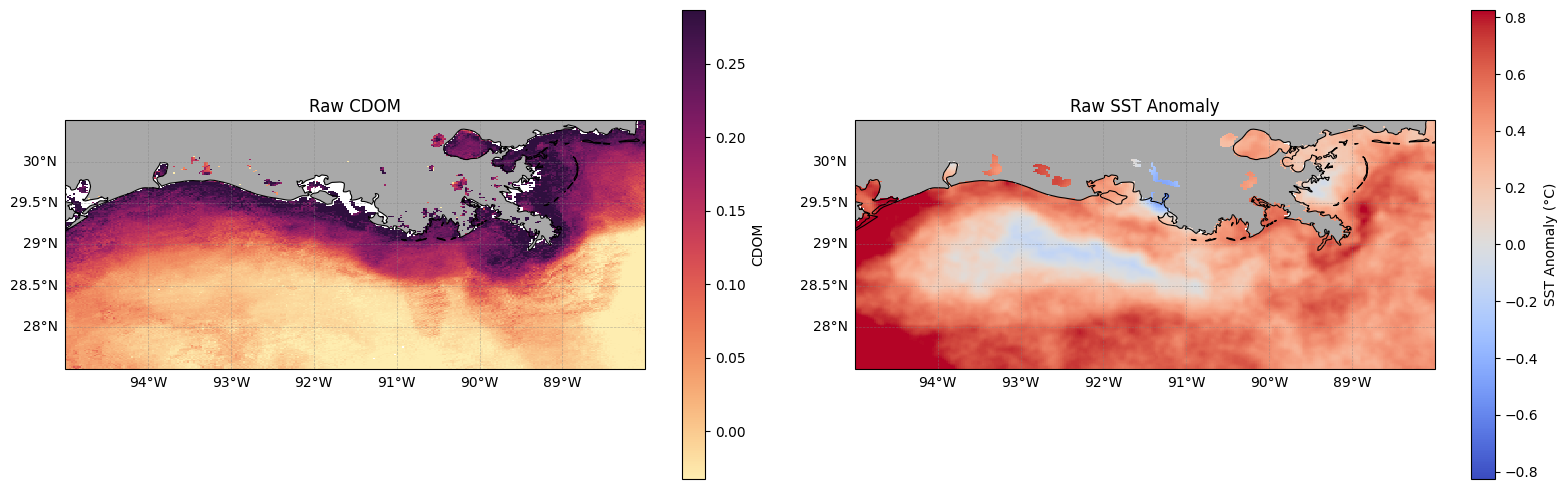

In [11]:
# Plot raw CDOM and SST Anomaly side by side for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), subplot_kw={'projection': ccrs.PlateCarree()})

# CDOM Plot (left)
ax1.set_extent([lon_edges_grid[0], lon_edges_grid[-1], lat_edges_grid[0], lat_edges_grid[-1]], crs=ccrs.PlateCarree())
cdom_valid = ~np.isnan(binned_cdom_interpolated)
if np.any(cdom_valid):
    cdom_vmin = np.percentile(binned_cdom_interpolated[cdom_valid], 5)
    cdom_vmax = np.percentile(binned_cdom_interpolated[cdom_valid], 95)
    cdom_plot = ax1.pcolormesh(lon_edges_grid, lat_edges_grid, binned_cdom_interpolated, 
                              cmap=cmocean.cm.matter, shading='auto',
                              vmin=cdom_vmin, vmax=cdom_vmax, transform=ccrs.PlateCarree())
    fig.colorbar(cdom_plot, ax=ax1, label='CDOM', shrink=0.7)
    
ax1.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')
ax1.add_feature(cfeature.LAND, facecolor='darkgray')
ax1.set_title('Raw CDOM')

# SST Anomaly Plot (right)
ax2.set_extent([lon_edges_grid[0], lon_edges_grid[-1], lat_edges_grid[0], lat_edges_grid[-1]], crs=ccrs.PlateCarree())
ssta_valid = ~np.isnan(binned_sst_anom_interpolated)
if np.any(ssta_valid):
    ssta_abs = np.percentile(np.abs(binned_sst_anom_interpolated[ssta_valid]), 95)
    ssta_plot = ax2.pcolormesh(lon_edges_grid, lat_edges_grid, binned_sst_anom_interpolated,
                              cmap='coolwarm', shading='auto', 
                              vmin=-ssta_abs, vmax=ssta_abs, transform=ccrs.PlateCarree())
    fig.colorbar(ssta_plot, ax=ax2, label='SST Anomaly (°C)', shrink=0.7)

ax2.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')
ax2.add_feature(cfeature.LAND, facecolor='darkgray')
ax2.set_title('Raw SST Anomaly')

# Add gridlines
for ax in [ax1, ax2]:
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

plt.tight_layout()
plt.show()

### Visualizing the Combined Product

This plot shows the result of multiplying the indexed CDOM (0-1) with the normalized SST Anomaly (-1 to 1).

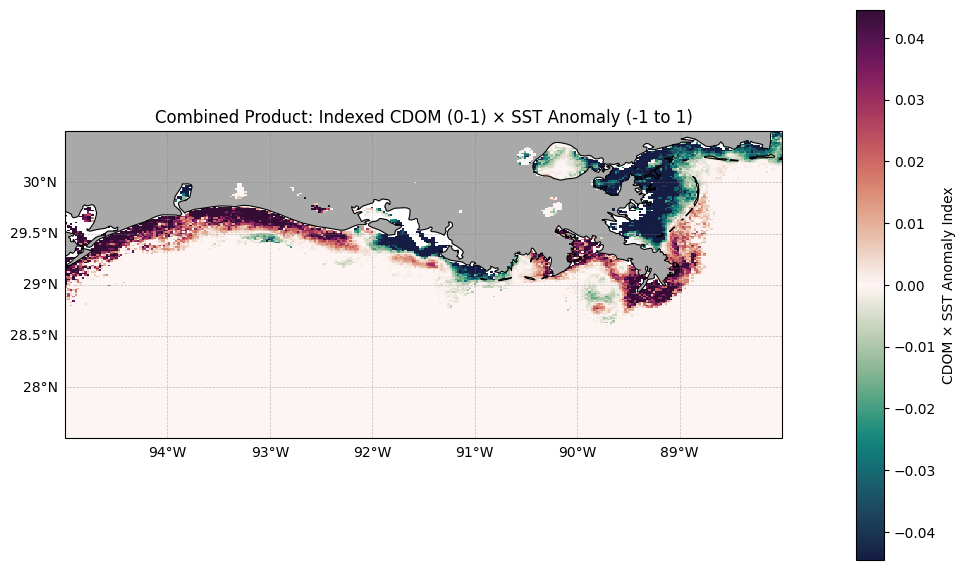

In [16]:
# Plot the combined product
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_edges_grid[0], lon_edges_grid[-1], lat_edges_grid[0], lat_edges_grid[-1]], crs=ccrs.PlateCarree())

# Find appropriate color limits
combined_valid = ~np.isnan(combined_product)
if np.any(combined_valid):
    combined_abs = np.percentile(np.abs(combined_product[combined_valid]), 95)
    comb_vmin, comb_vmax = -combined_abs, combined_abs
else:
    comb_vmin, comb_vmax = -1, 1

# Plot the combined product
combined_plot = ax.pcolormesh(lon_edges_grid, lat_edges_grid, combined_product,
                            cmap=cmocean.cm.curl, shading='auto',
                            vmin=comb_vmin, vmax=comb_vmax, transform=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=3)
ax.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add colorbar
cbar = fig.colorbar(combined_plot, ax=ax, label='CDOM × SST Anomaly Index', shrink=0.7, pad=0.08)

plt.title("Combined Product: Indexed CDOM (0-1) × SST Anomaly (-1 to 1)", fontsize=12)
plt.tight_layout(pad=0.5)
plt.show()